# Objectifs du travail: 

Notre travail consiste en une implémentation d’un algorithme génétique, pour résoudre un problème d’optimisation de transport de marchandise par des camions. Ensuite, on abordera le problème du plus court chemin, en programmant un GPS, par l’utilisation de l’algorithme de Dijkstra. On comparera les résultats obtenus avec ceux de l’algorithme génétique



# 1ère Partie : Algorithme génétique 


## Présentation du problème :  

On considère une distribution de N maisons différentes dans lesquelles il faut faire des livraisons. Un camion de livraison assure celle-ci, et dispose d’une capacité de chargement limitée. Hormis son point de départ, ce camion ne peut passer qu’une seule fois par chaque maison. Le camion doit revenir vers son point de départ, à l’entrepôt, pour reprendre de la marchandise. 


## Préliminaire : 

In [65]:
import random as rd
import math as math
import statistics
import matplotlib.pyplot as plt

N = 10 #Nombre de maisons
p = 100 #Taille de la population

coordonnesMaisons=[[-91,-30],[40,46] , [-64,90] , [-16,-70] , [55,70] , [-37,69] , [13,-44] , [68,-76] , [-92,12] , [74,23]]

poidsDemande=[2,3,5,1,4,6,1,2,3,2] 
capCamion=9

omega=1

probabiliteCroisement=1
probabiliteMutation=1

proportionGeneration = 2.75/5


## Première Version 

### Présentation de la méthode 

L’idée est de créer une population de solutions, que l’on fait se reproduire.
Au fil des générations, selon le modèle de la théorie de l’évolution, une portion de la population est remplacée, 
la plus faible. Elle laisse place à sa meilleure progéniture. Au bout d’un nombre donné d’itérations, on choisit 
la meilleure solution parmi la dernière génération. Les solutions sont des listes qui contiennent les numéros des villes par lesquelles le camion passe, séparés par des zéros (qui traduisent le départ d'un nouveau camion), tout en respectant les contraintes du problème. 


### construction d'une solution de départ (de N individu)

Nous avons implémenté une fonction creeIndividu() qui prend en argument N, soit la taille d’un individu (le nombre de maisons qui doivent être visitées par l’ensemble des camions)         

L’idée de cette fonction créatrice de solution est de fournir une solution initialement purement aléatoire, puis de vérifier qu’elle respecteles critères suivants               

. Deux 0 ne peuvent se suivre : cela n’a aucune utilité qu’un camion fasse un tour au cours duquel  il ne rend visite à aucun client      

. On ne peut pas non plus avoir 2 fois le même nombre non nul dans une même solution : on ne rend pas 2 fois visite à un même client)      

. La solution commence et se termine avec des 0 : les camions partent du hangar et y retournent      

Étapes de l'algorithme :   

1) On crée une liste de d’éléments contenant les nombres 0 jusqu’à N  
2) On la mélange   
3) On ajoute aléatoirement des 0  
4) On supprime les 0 doubles qui se suivent  
5) On ajoute un 0 au début et à la fin   

In [66]:
def creeIndividu(N):
    endroitsPossiblesZero = [ i for i in range (N)]

    solution = []
    
    while(not solutionValide(solution)):
        
        #Initialise la solution avec toutes les maisons dans l'ordre
        solution = [ i+1 for i in range(N)]
        
        #Mélange au hasard les routes
        rd.shuffle(solution)

        #Rajoute au hasard des 0 dans la solution
        rd.shuffle(endroitsPossiblesZero)
        solution.insert(endroitsPossiblesZero[0],0)
        solution.insert(endroitsPossiblesZero[1],0)
        solution.insert(endroitsPossiblesZero[2],0)
        
        #Insère des 0 au début et à la fin de la solution
        solution.insert(0,0)
        solution.append(0)
                    
        #Supprime les 0 en trop
        j = 0
        while ( j < (len(solution)-2) ):
            if(solution[j]==solution[j+1] and solution[j]==0):
                solution.pop(j)
            j+=1
            
    return(solution)


Comme les solutions crées par l'algorithme précédent sont aléatoires, il convient de vérifier s'ils répondent aux contraintes de la livraison. Ainsi, on va vérifier que chaque camion n'a pas d'itinéraire qui l'oblige a livrer des courses supérieures à sa capacité. On va implémenter une fonction solutionvalide() qui se base elle-même sur 2 autres fonctions, celles qui ont respectivement pour but de vérifier que les trajets sont valides et que la capacité des camions est respectée.


La première fonction respectTrajet() vérifie que toutes les maisons sont bien visitées une et une seule fois

In [67]:
def respectTrajet(solution):
    n = len(solution)
    maisonsVisitees = [ False for i in range(N)]

    for i in range(n): #Teste les doublons
        if(solution[i]!=0):
            if (maisonsVisitees[solution[i]-1]):
                return False
            else:
                maisonsVisitees[solution[i]-1]=True
    
    for i in range(N): #Teste si chaque maison est visitée au moins une fois
        if(not maisonsVisitees[i]):
            return False
            
    return True

la deuxième fonction est respectPoids(). Elle fait la somme des poids des demandes entre deux 0 consécutifs de la solution (i.e la somme des poids attribués à un seul et même camion) et vérifie ensuite que cette somme est inférieure à la capacité du camion.


In [68]:
def respectPoids(solution): #Capcamion = Poids max par camion - Poidsdemande=liste des poids de chaque maison
    somme = 0
    n = len(solution)
    i=0
    while(i<n and somme<=capCamion):
        if(solution[i]==0):
            somme=0
        else:
            maison=solution[i]-1
            somme += poidsDemande[maison]
        i+=1
        
    return(somme <= capCamion)

Ainsi, on a la fonction solutionValide()

In [69]:
def solutionValide(solution):
    if(solution==[]):
        return(False)
    else:
        return( respectPoids(solution) and respectTrajet(solution) )


### Classification des individus au sein d’une population

On attribue à chaque individu un cout propre
Une matrice de cout (symétrique à diagonale nulle) représente le cout de trajet (la distance par exemple) entre les villes i et j : $ C_{i,j} = C_{j,i} $ est la distance entre i et j
Un poids supplémentaire est ajouté à chaque fois que l’on reviens au hangar


Equation du coût : $$F(x) = \omega*N(x)+ S(C_{i,j})$$

On calcule d'abord la matrice coût 

In [70]:
matricecout = []
for i in range(N):
    distances = [] 
    for j in range(N):
        distances.append( int( math.sqrt ( (coordonnesMaisons[i][0]-coordonnesMaisons[j][0])**2 + (coordonnesMaisons[i][1]-coordonnesMaisons[j][1])**2 ) ) )
    matricecout.append(distances)

print(matricecout)

[[0, 151, 123, 85, 176, 112, 104, 165, 42, 173], [151, 0, 112, 128, 28, 80, 93, 125, 136, 41], [123, 112, 0, 167, 120, 34, 154, 212, 82, 153], [85, 128, 167, 0, 156, 140, 38, 84, 111, 129], [176, 28, 120, 156, 0, 92, 121, 146, 158, 50], [112, 80, 34, 140, 92, 0, 123, 179, 79, 120], [104, 93, 154, 38, 121, 123, 0, 63, 119, 90], [165, 125, 212, 84, 146, 179, 63, 0, 182, 99], [42, 136, 82, 111, 158, 79, 119, 182, 0, 166], [173, 41, 153, 129, 50, 120, 90, 99, 166, 0]]


Les fonctions nbrVehicules ( ) et coutsolution ( ) nous donnent respectivement $N(x)$ et $F(x)$ pour une solution


La fonction nbrVehicules ( ) nous donne le nombre de camions utilisés, qui est égale au nombre de trajets différents, i.e au (nombre de 0) - 1 présent dans la solution

In [71]:
def nbrvehicules(solution):
    n = len(solution)
    somme =0
    for i in range(n):
        if solution[i]==0:
            somme +=1
    somme -=1
    return somme

On calcule le coût de la solution, en se donnant la matrice de coût, et un facteur omega

In [73]:
def coutsolution(solution):
    n = len(solution)
    cout = omega*nbrvehicules(solution)
    for i in range(n-1):
        cout += matricecout[solution[i]-1][solution[i+1]-1]
    return cout

Pour sélectionner les meilleurs individus nous choisissons de d’abord les ranger dans l’ordre croissant selon le critère de coût.

Pour ce faire, on considère une population (en d’autres termes une liste de solution)

In [74]:
def initPopulation(p,N):
    population = []
    for i in range(p):
        population.append(creeIndividu(N))
    return population

Les solutions sont rangées dans l’ordre décroissant de coût.
La sélection des individus se fait à l’aide des fonctions listecoutpopulation( ) et tripopulation( )

On commence par calculer le coût de toute la population par listecoutpopulation( ) 

In [75]:
def listecoutpopulation(population):
    n = len(population)
    L=[]
    for i in range(n):
        L.append (coutsolution(population[i]))
    return L

Enfin, on recrée une deuxième liste qui cette fois contient effectivement les solutions dans l’ordre croissant selon le critère de coût.
Pour ce faire, on parcourt la liste des coûts, triée par la fonction sort, en même que celle des solutions et lorsque l’on trouve une solution qui a le coût recherché, on l’ajoute à notre nouvelle liste et on l’enlève de l’ancienne

In [76]:
def tripopulation(population):
    K=[]
    n =len(population)
    L = listecoutpopulation(population)
    L.sort()
    for i in range(len(population)):
        j=0
        while j < len(population) and coutsolution(population[j]) != L[i]:
            j +=1
        K.append(population[j])
        del population[j]
    return K

### Passage d’une génération à l’autre

#### Opérateurs génétiques : Croissements et mutations

##### Croisements à un point :  (ici 4ème)   
Exemple :   
  
A=3040 | 153010    
B=1020 | 1351040   

croisement : 
  
A’ = 3040 | 1351040    
B’= 1020  | 15301

##### Mutation

a) Opérateur asexué : il n’a besoin que d’un seul parent pour générer un chromosome enfant.

b) Permet d’éviter les solutions uniformes et donc, les optimums locaux.

c) On choisit un gène quelconque et on le modifie, on le fait sur plusieurs gènes afin d’avoir des chances d’obtenir une solution valide

#### Modèle de recombinaison

1) On regroupe la génération n en paires   
2) Pour chaque paire on effectue un croisement si possible (500 essais) avec une probabilité P1 élevée  
3) Aux individus obtenus on applique une mutation avec une probabilité P2 faible   
3) On obtient alors la génération n+1   

On réalise plusieurs itérations du croisement, ici 500 fois, car il y’a peu de chances d’avoir un bon croisement du premier coup. On se base sur la méthode du croisement à un seul point dans cette version de l’algorithme. Nous prenons donc une partie d’un des individus parents, puis nous prenons la partie manquante au deuxième parent. S’il n’y a pas de croisement, on renvoie le premier parent, qui est celui avec le meilleur score.
Après avoir effectué ce croisement, on réalise la mutation sur un nombre aléatoire de gènes de l’individu, car il y a, comme nous l’avons déjà dit, peu de chance que l’individu crée soit une solution valide du problème.
Ce code permet de remplacer les gènes de l’individu par un autre aléatoire, i.e. remplace une maison visitée par une autre.

In [77]:
def recombinaison(individu_1,individu_2): #On suppose qu'à ce moment, la population est ordonnée avec les meilleures solutions en premier
        
    individu_3=[]
    
    recombinaisonEffectuee = 0
    recombinaisonTotale = 500
    
    while(recombinaisonEffectuee < recombinaisonTotale and (not solutionValide(individu_3))) :
        
        #print("Recombinaison numéro " + str(recombinaisonEffectuee))
        
        individu_3=[]

        if(rd.random()<probabiliteCroisement):
            
            #Croisement à un point:
            pointDeCroisement = rd.randrange(2,min( len(individu_1) , len(individu_2) ) - 2 )
            
            #print("Point de Croisement : " + str(pointDeCroisement))

            for j in range(pointDeCroisement):
                individu_3.append(individu_1[j])
            for j in range(pointDeCroisement,len(individu_2)):
                individu_3.append(individu_2[j])

        else:
            for j in range(len(individu_1)):
                individu_3.append(individu_1[j])
                
        #print("Après croisement : ")        
        #print(individu_3)
        
        if(rd.random()<probabiliteMutation):
            
            #print("Mutation!")
            
            nombreDeMutation = rd.randrange(0,len(individu_3)) #Nombre de mutations à faire
            
            for j in range(nombreDeMutation) :
                individu_3[rd.randrange(1,len(individu_3)-1)] = rd.randrange(0,N)
            
            #print(individu_3)

        recombinaisonEffectuee += 1
            
    
    if(not solutionValide(individu_3)):
        #print("Pas de solution")
        individu_3 = individu_1
              
    return(individu_3)

cette fonction permet de créer une nouvelle population a partir de la population initiale. Pour ce faire, on segmente la population en deux, selon une proportion donnée. Cette proportion sera conservée dans la nouvelle. Ensuite, on rempli le reste de la nouvelle population avec la descendance issue du croisement du reste des individus de la population initiale. 

In [78]:
def selectionPopulation(population):
    n=len(population)
    nouvelle_population=[]
    for i in range( int(n * proportionGeneration )):
        nouvelle_population.append(population[i])
    j=0
    while(len(nouvelle_population) != p ):
        nouvelle_population.append ( recombinaison(population[j],population[j+1] ) )
        j+=2
    return(nouvelle_population)

On observe, cependant rapidement un effet palier. Pour résoudre ça, on choisit d'introduire dix (ou un autre nombre arbitraire) nouveaux individus. Cela pourrait paraitre, à priori, contreproductif étant donné que les individus aléatoires ont plus de chance d'avoir un coût élévé. Cependant, il se trouve qu'intégrer des individus aléatoires dans la population, même s'il sont "moins bons" permet de la diversifier et donc d'éviter d'avoir des individus trop ressemblants, qui en les croisant amènent à un effet palier. 

In [79]:
def selectionPopulation2(population):
    n=len(population)
    nouvelle_population=[]
    for i in range( int(n * proportionGeneration )):
        nouvelle_population.append(population[i])
    j=0
    while(len(nouvelle_population) != p - 10 ):
        nouvelle_population.append ( recombinaison(population[j],population[j+1] ) )
        j+=2
    while(len(nouvelle_population) != p):
        nouvelle_population.append(creeIndividu(N))
        
        
    return(nouvelle_population)

### Regroupement de l'algorithme 

##### On reprend les fonctions déjà crées afin de coordonner le tout selon les étapes suivantes :

1) Initialisation d’une population aléatoire  

2) Calcul du cout de chaque individu   

3) Sélection des meilleurs  

4) Recombinaison et mutations afin de créer une nouvelle génération   

Au bout d’un nombre d’itérations fixées, on choisit le meilleur individu de l’ultime génération comme solution optimisée au problème


Génération 0 : Coût = 15.1547
Génération 100 : Coût = 12.419400000000001
Génération 200 : Coût = 12.419400000000001
Génération 300 : Coût = 12.3156
Génération 400 : Coût = 12.22
Génération 500 : Coût = 12.11
Génération 600 : Coût = 12.11
Génération 700 : Coût = 12.130799999999999
Génération 800 : Coût = 12.11
Génération 900 : Coût = 12.11
Génération 1000 : Coût = 12.11
Génération 1100 : Coût = 12.11
Génération 1200 : Coût = 12.1216
Génération 1300 : Coût = 12.11
Génération 1400 : Coût = 12.11
Génération 1500 : Coût = 12.11
Génération 1600 : Coût = 12.1174
Génération 1700 : Coût = 12.1208
Génération 1800 : Coût = 12.11
Génération 1900 : Coût = 12.11
Génération 2000 : Coût = 12.11
Génération 2100 : Coût = 12.11
Génération 2200 : Coût = 12.1208
Génération 2300 : Coût = 12.11
Génération 2400 : Coût = 12.11
Génération 2500 : Coût = 12.11
Génération 2600 : Coût = 12.11
Génération 2700 : Coût = 12.11
Génération 2800 : Coût = 12.1359
Génération 2900 : Coût = 12.11
Génération 3000 : Coût = 12.1

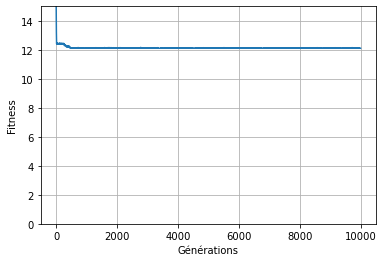

In [80]:
population = initPopulation(p,N)

NbGenerations = 10000

coutPopulations=[] #Représente la moyenne des couts de chaque génération

MeilleurCheminGeneration = [] #Prend le meilleur chemin toutes les 100 générations

for i in range( NbGenerations ):
    
    cout = statistics.mean( listecoutpopulation(population) ) / 100
    coutPopulations.append( cout )
    
    if(i%100==0):
        print("Génération " + str(i) + " : Coût = " + str(cout) )
        MeilleurCheminGeneration.append(population[0])
    
    pop1 = tripopulation(population)
    pop2 = selectionPopulation(pop1)
    
    population.clear()
    
    for j in range(p):
        population.append(pop2[j])

x=[i for i in range(NbGenerations)]

print(tripopulation(population)[0])


#affichage : 
axes = plt.gca()
axes.set_ylim([0,15])

plt.xlabel("Générations")
plt.ylabel("Fitness")

plt.grid(True)

plt.plot(x,coutPopulations)
plt.show()

### Résultats et remarques 

Nous pouvons faire plusieurs tests en variant les paramètres pour voir lesquels influencent sur la vitesse de convergence, ainsi que sur la qualité des chemins proposés

### Effet palier

On remarque aussi qu’il existe de longs paliers au cours  desquels il n’y pas d’amélioration du fitness au sein de la population.
On peut certainement ici voir le début des limites du modèle génétique pour cet exercice (bien qu’il est donné de très bon résultats).
En effet, le modèle de croisement en un point n’est pas forcément adapté à l’exercice : lorsque l’on prend 2 solutions et que l’on en crée deux autres en fusionant les moitiés respectives des premières, il n’est pas garanti que le résultat soit une solution. En effet la capacité du camion étant limitée il se peut (et c’est même probable) que l’on obtienne en concaténant deux moitiés de solutions un chemin trop long pour la capacité du camion. Le nombre de solutions effectivement issues de croisement qui améliore le fitness se trouve ainsi irrémédiablement diminué ce qui explique la présence de minimas locaux qui se traduisent par la visualisation d’un effet palier.

### Deuxième tentative : 

Pour cette tentative on randomisé la map de départ, et on a essayer d'améliorer le croisement et la mutation pour éviter les effets palier et converger plus vite. Malheureusement, on a pas eu le temps de bien finaliser cette amélioration

In [ ]:
import numpy as np
import random as rd
from matplotlib import pyplot as plt

def mutation(L):
    n = len(L)
    a,b = rd.randint(1,n-1),rd.randint(1,n-1)
    c = L[a]
    L[a] = L[b]
    L[b] = c
    return L



L=[0,3,7,2,1,4,6,5]


def placedepots(N, taille_carte):
    L = []
    for i in range(N):
        L.append([rd.random(), rd.random()])
    for j in range(N):
        L[j][0] = int(L[j][0]*taille_carte)
        L[j][1] = int(L[j][1]*taille_carte)
    return L




def affichage_maisons(L):
    for i in range(len(L)):
        plt.plot(L[i][0], L[i][1], marker = "o")
    plt.show()



x=np.linspace(0,5,50)
y=np.sin(2 * np.pi * x)



def indice_break(L1,L2) :
    n1 = len(L1)
    n2 = len(L2)
    n3 = min(n1,n2)
    somme = 0
    for i in range(n3):
        if L1[i] == L2[i]:
            somme +=1
        else :
            return somme



def aide_croisement(population):
    K = []
    while len(population) > 1:
        partenaire = 0
        taille_max = 0
        for j in range(1, len(population)):
            if indice_break(population[0], population[j])> taille_max:
                partenaire = j
                taille_max = indice_break(population[0], population[j])
        K.append([population[0],population[partenaire],taille_max])
        population.pop(partenaire)
        population.pop(0)
    return K

## test unitaire pour la fonction aide_croisement : 

assert len(aide_croisement(initPopulation(100,100))) == len((initPopulation(100,100)))//2


def tri3(L):
    for i in range(len(L)):
        for j in range(i,len(L)):
            if L[j][2]>L[i][2]:
                c = L[i]
                L[i] = L[j]
                L[j] = c
    return L



def tri_3(tab):
    n = len(tab)
    for i in range(n):
        for j in range(0, n-i-1):
            if tab[j][2] < tab[j+1][2] :
                tab[j], tab[j+1] = tab[j+1], tab[j]
    return tab


def croisement(p1, p2, point_cr):
    L1 = []
    L2 = []
    for i in range(point_cr):
        L1.append(p1[i])
        L2.append(p2[i])
    for i in range(point_cr,len(p1)):
        L2.append(p1[i])
    for i in range(point_cr, len(p2)):
        L1.append(p2[i])

        #print("Mutation!")
    L1=mutation(L1)
    while(not solutionValide(L1)):
        L1 = mutation(L1)


        #print("Mutation!")
    L2=mutation(L2)
    while(not solutionValide(L2)):
            L2=mutation(L2)
    return(L1, L2)


# p individus --> P/2 paires ---> un certain nombre en K --->




def si_croisement(pop, seuil):
    # ici on suppose que la population est déja triée selon la fonction tri3
    K = []

    i = 0
    while pop[i][2] >= seuil and i!= len(pop)-1:
        A = croisement(pop[i][0], pop[i][1],pop[i][2])
        K.append(A[0])
        K.append(A[1])
        i += 1
    J = []
    for i in range(int(len(pop)-(len(K)/2))):
        J.append(pop[i+len(K)//2][0])
        J.append(pop[i+len(K)//2][1])
    K= K+J

    return (K)